In [80]:
import numpy as np
from quantecon.game_theory import lemke_howson, NormalFormGame, Player
import scipy.optimize as op

Lemke-Howson Algorithm

In [2]:
def pivoting(tableau, basic_vars, pivot):
    
    ind_nonpositive = tableau[:, pivot] <= 0
    with np.errstate(divide='ignore'):
        ratios = tableau[:, -1] / tableau[:, pivot]
    ratios[ind_nonpositive] = np.inf
    
    row_min = ratios.argmin()
    tableau[row_min, :] /= tableau[row_min, pivot]
    for i in range(tableau.shape[0]):
        if i != row_min:
            tableau[i, :] -= tableau[i, pivot] * tableau[row_min, :]
    basic_vars[row_min], pivot = pivot, basic_vars[row_min]
    return pivot

In [3]:
def create_tableau(A, B):
    B_T = B.T
    m, n = A.shape
    tableaus = []
    for i in range(2):
        tableaus.append(np.empty((A.shape[1-i], m+n+1)))
        tableaus[i][:, :m] = [B_T, np.identity(m)][i]
        tableaus[i][:, m:m+n] = [np.identity(n), A][i]
        tableaus[i][:, -1] = 1
    basic_vars_list = [np.arange(m, m+n), np.arange(m)]
    
    return tableaus, basic_vars_list

In [7]:
def Lemke_Howson(A, B, init_pivot):
    m, n = A.shape
    pivot = init_pivot
    tableaus, basic_vars_list = create_tableau(A, B)
    players = [init_pivot // m, 1 - init_pivot // m]
    while True:
        for i in players:
            #print(i, tableaus[i])
            pivot = pivoting(tableaus[i], basic_vars_list[i], pivot)
            #print(tableaus[i], basic_vars_list[i])
            if pivot == init_pivot:
                break
        else:
            continue
        break
        
    #summarize the found NE
    out = np.zeros(m+n)
    for i, (start, num) in enumerate(zip([0, m], [m, n])):
        ind = basic_vars_list[i] < start + num if i == 0 else start <= basic_vars_list[i]
        out[basic_vars_list[i][ind]] = tableaus[i][ind, -1]
        out[start:start+num] /= out[start:start+num].sum()
    
    return out[:m], out[m:]

Imitation

In [5]:
def create_imitation(x, y):
    n = x.shape[0]
    A = np.empty((n, n))
    B = np.eye(n)
    
    for i in range(len(x)):
        A[i, :] = -(x[i] - y) ** 2
    
    if A.min() <= 0:
        A += A.min() * (-1) + 1.
        
    return A, B

In [32]:
def imitation_to_kakutani(F):
    
    x = np.array([1])
    y = np.array([F(x[-1])])
    epsilon = 10e-15

    #Because we may meet some bugs, we need to avoid infinite loop and dead kernel
    count = 0

    while True:
        
        A, B = create_imitation(x, y)
        init_pivot = 0
        rho = Lemke_Howson(A, B, init_pivot)[1]
        x = np.append(x, np.dot(rho, y))
        y = np.append(y, F(x[-1]))

        if np.abs(y[-1] - x[-1]) < epsilon:
            break

        #break when loop over 100 times no matter convergence or not
        count += 1
        if count > 20:
            break
    
    return x, y

In [39]:
x1, y1 = imitation_to_kakutani(lambda x: 0.5 * x - 1)
x2, y2 = imitation_to_kakutani(lambda x: -0.2 * x + 2)
x3, y3 = imitation_to_kakutani(lambda x: -0.2 * x ** 2 + 2)

In [41]:
print(x1, x2, x3)

[ 1.         -0.5        -1.25       -1.625      -1.8125     -1.90625
 -1.953125   -1.9765625  -1.98828125 -1.99414062 -1.99707031 -1.99853516
 -1.99926758 -1.99963379 -1.99981689 -1.99990845 -1.99995422 -1.99997711
 -1.99998856 -1.99999428 -1.99999714 -1.99999857] [ 1.          1.8         1.64        1.672       1.6656      1.66688
  1.666624    1.6666752   1.66666496  1.66666701  1.6666666   1.66666668
  1.66666666  1.66666667  1.66666667  1.66666667  1.66666667  1.66666667
  1.66666667  1.66666667  1.66666667  1.66666667] [ 1.          1.8         1.4         1.6         1.5         1.55        1.525
  1.534875    1.5299375   1.53185825  1.53089787  1.53127034  1.53108411
  1.53115629  1.5311202   1.53113419  1.53112719  1.5311299   1.53112855
  1.53112907  1.53112881  1.53112891]


In [42]:
-1 / (1 - 0.5)

-2.0

In [43]:
2 / (1 + 0.2)

1.6666666666666667

In [51]:
op.fsolve(lambda x: -0.2 * x ** 2 + 2 - x, 1)

array([ 1.53112887])

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

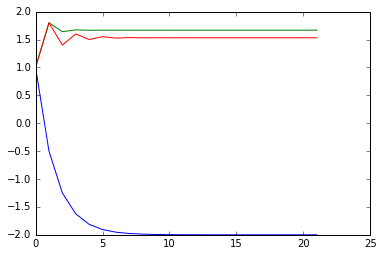

In [53]:
plt.figure()
for x in [x1, x2, x3]:
    plt.plot(range(len(x)), x)
plt.show()

Use lemke_howson function of QuantEcon package

In [63]:
def imitation_to_kakutani2(F):
    
    x = np.array([1])
    y = np.array([F(x[-1])])
    epsilon = 10e-15

    #Because we may meet some bugs, we need to avoid infinite loop and dead kernel
    count = 0

    while True:
        
        A, B = create_imitation(x, y)
        q = NormalFormGame((Player(A), Player(B)))
        init_pivot = 0
        rho = lemke_howson(q, init_pivot)[1]
        x = np.append(x, np.dot(rho, y))
        y = np.append(y, F(x[-1]))

        if np.abs(y[-1] - x[-1]) < epsilon:
            break

        #break when loop over 100 times no matter convergence or not
        count += 1
        if count > 20:
            break
    
    return x, y

In [66]:
x1, y1 = imitation_to_kakutani(lambda x: 0.5 * x - 1)
x2, y2 = imitation_to_kakutani(lambda x: -0.2 * x + 2)
x3, y3 = imitation_to_kakutani(lambda x: -0.2 * x ** 2 + 2)

In [68]:
print(x1, x2, x3)

[ 1.         -0.5        -1.25       -1.625      -1.8125     -1.90625
 -1.953125   -1.9765625  -1.98828125 -1.99414062 -1.99707031 -1.99853516
 -1.99926758 -1.99963379 -1.99981689 -1.99990845 -1.99995422 -1.99997711
 -1.99998856 -1.99999428 -1.99999714 -1.99999857] [ 1.          1.8         1.64        1.672       1.6656      1.66688
  1.666624    1.6666752   1.66666496  1.66666701  1.6666666   1.66666668
  1.66666666  1.66666667  1.66666667  1.66666667  1.66666667  1.66666667
  1.66666667  1.66666667  1.66666667  1.66666667] [ 1.          1.8         1.4         1.6         1.5         1.55        1.525
  1.534875    1.5299375   1.53185825  1.53089787  1.53127034  1.53108411
  1.53115629  1.5311202   1.53113419  1.53112719  1.5311299   1.53112855
  1.53112907  1.53112881  1.53112891]


Compare the speed of homemade Lemke_Howson function and the one from QuantEcon package

In [86]:
%timeit imitation_to_kakutani(lambda x: 0.5 * x - 1)

10 loops, best of 3: 55.9 ms per loop


In [87]:
%timeit imitation_to_kakutani2(lambda x: 0.5 * x - 1)

100 loops, best of 3: 2.86 ms per loop
